# Multilayer perceptron

Реализовать MLP

In [6]:
import math
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

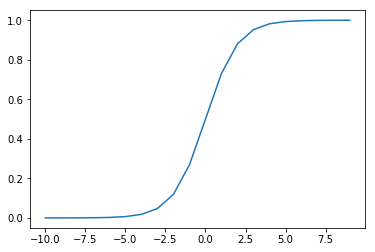

In [61]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

p = np.array([sigmoid(i) for i in range(-10, 10, 1)])
plt.plot(range(-10, 10, 1), p)
plt.show()

In [72]:
class Neuron():
    def __init__(self, dim = 1, rst = 0):
        self.dim = dim
        self.rst = rst
        ran = np.random.RandomState(self.rst)
        self.w = ran.randint(low=0, high=2, size=self.dim) - 0.5
        self.dw = np.array([0 for _ in range(dim)])
        
    def calc(self, x):
        if (x.shape[0] != self.dim):
            print "Error"
        return sigmoid(np.sum(x*self.w))

In [74]:
x = np.array([0.3, 0.4, 0.2, 0.8, 0.2])
n = Neuron(dim=x.shape[0], rst=0)
print n.w
print n.calc(x)

[-0.5  0.5  0.5 -0.5  0.5]
0.462570154656


In [1]:
class MLP():
    def __init__(self):
        pass
    def fit(self):
        pass
    def predict(self):
        pass